In [1]:
upos_maps={'a':'ADJ', 'p':'ADP', 'd':'ADV',
           'u':'AUX', 'c':'CCONJ', 'h':'DET',
           'e':'INTJ', 'n':'NOUN', 'm':'NUM',
           'z':'PART', 'r':'PRON', 'nh':'PROPN',
           'wp':'PUNCT', 'ws':'SYM',
           'v':'VERB', 'x':'X'
          }
upos_rev_maps={'SCONJ':['c'], 'NOUN':['ni', 'nl', 'ns', 'nt', 'nz', 'n', 'nd', 'nh']}

class WordUnit(object):
    def __init__(self, i, text, dependency_relation, governor, head_text, pos, netag):
        self.i=i
        self.text=text
        self.lemma=text
        self.dependency_relation=dependency_relation
        self.governor=governor
        self.head_text=head_text
        self.pos=pos
        self.upos='X'
        if pos in upos_maps:
            self.upos=upos_maps[pos]
        else:
            for k,v in upos_rev_maps.items():
                if pos in v:
                    self.upos=k
        self.netag=netag

送 --> 我|SBV|r|O
花 --> 送|HED|v|O
送 --> 她|IOB|r|O
束 --> 一|ATT|m|O
花 --> 束|ATT|q|O
送 --> 花|VOB|n|O
verb_domains(送)


,rel,index,text,lemma,children,features
0,sbv,1,我,我,[我],"[c_pron, x_r]"
1,iob,3,她,她,[她],"[c_pron, x_r]"
2,vob,6,花,花,"[一, 束, 花]","[c_noun, x_n]"


vob -> 一 束 花
index: 1	text: 我 	lemma: 我	upos: PRON	xpos: r
index: 2	text: 送 	lemma: 送	upos: VERB	xpos: v
index: 3	text: 她 	lemma: 她	upos: PRON	xpos: r
index: 4	text: 一 	lemma: 一	upos: NUM	xpos: m
index: 5	text: 束 	lemma: 束	upos: X	xpos: q
index: 6	text: 花 	lemma: 花	upos: NOUN	xpos: n
我 -> sbv, 2, 送
送 -> hed, 0, _root_
她 -> iob, 2, 送
一 -> att, 5, 束
束 -> att, 6, 花
花 -> vob, 2, 送
('我', 2, 'sbv')
('送', 0, 'hed')
('她', 2, 'iob')
('一', 5, 'att')
('束', 6, 'att')
('花', 2, 'vob')


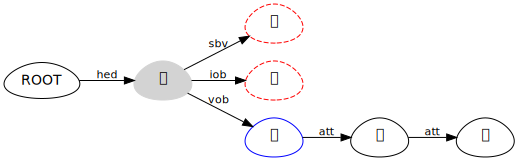

In [2]:
from sagas.nlu.uni_intf import WordIntf, SentenceIntf
from sagas.nlu.corenlp_parser import get_chunks
import sagas
from sagas.tool.misc import print_stem_chunks
from sagas.nlu.uni_viz import EnhancedViz

class RootWordImpl(WordIntf):
    def setup(self, token):
        features = {'index':0, 'text':'ROOT', 'lemma':'root', 'upos':'', 'xpos':'',
                    'feats':[], 'governor':0, 'dependency_relation':''}
        return features
class LtpWordImpl(WordIntf):
    def setup(self, token):
        if token.dependency_relation=='HED':
            governor=0
        else:
            governor=token.governor
        idx=token.i+1  # start from 1
        features = {'index':idx, 'text':token.text, 'lemma':token.lemma, 
                    'upos':token.upos, 'xpos':token.pos,
                    'feats':[], 'governor':governor, 'dependency_relation':token.dependency_relation.lower(),
                    'entity':[token.netag]
                   }
        return features

class LtpSentImpl(SentenceIntf):
    def setup(self, sent):
        words = []
        for word in sent:
            words.append(LtpWordImpl(word))
        deps = []        
        return words, deps
    
    def build_dependencies(self):
        for word in self.words:
            if word.governor == 0:
                # make a word for the ROOT
                governor = RootWordImpl(None)
            else:
                # id is index in words list + 1
                governor = self.words[word.governor-1]
            self.dependencies.append((governor, word.dependency_relation, word))

class LtpParserImpl(object):
    def __init__(self, lang='zh-CN'):
        self.lang = lang

    def __call__(self, sentence):
        from sagas.zh.ltp_procs import LtpProcs, ltp
        # doc = spacy_doc(sents, self.lang)
        words = ltp.segmentor.segment(sentence)
        postags = ltp.postagger.postag(words)
        arcs = ltp.parser.parse(words, postags)
        roles = ltp.labeller.label(words, postags, arcs)
        netags = ltp.recognizer.recognize(words, postags)
        
        doc=[]
        for i in range(len(words)):
            a = words[int(arcs[i].head) - 1]
            print("%s --> %s|%s|%s|%s" % (a, words[i], \
                                          arcs[i].relation, postags[i], netags[i]))
            unit=WordUnit(i=i, text=words[i], 
                          dependency_relation=arcs[i].relation.lower(), 
                          governor=arcs[i].head, 
                          head_text=a, pos=postags[i], netag=netags[i])
            rel=unit.dependency_relation
            doc.append(unit)
        return LtpSentImpl(doc)

p=LtpParserImpl()
doc=p('我送她一束花')
# print(doc.words)
doc.build_dependencies()
# print(doc.dependencies)
rs = get_chunks(doc)
# print(rs)
for r in rs:
    df = sagas.to_df(r['domains'], ['rel', 'index', 'text', 'lemma', 'children', 'features'])
    print('%s(%s)' % (r['type'], r['lemma']))
    # sagas.print_df(df)
    display(df)
    print_stem_chunks(r)
    
cv = EnhancedViz(shape='egg', size='8,5', fontsize=20)
cv.analyse_doc(doc, None)